In [1]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):

    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    return param_count


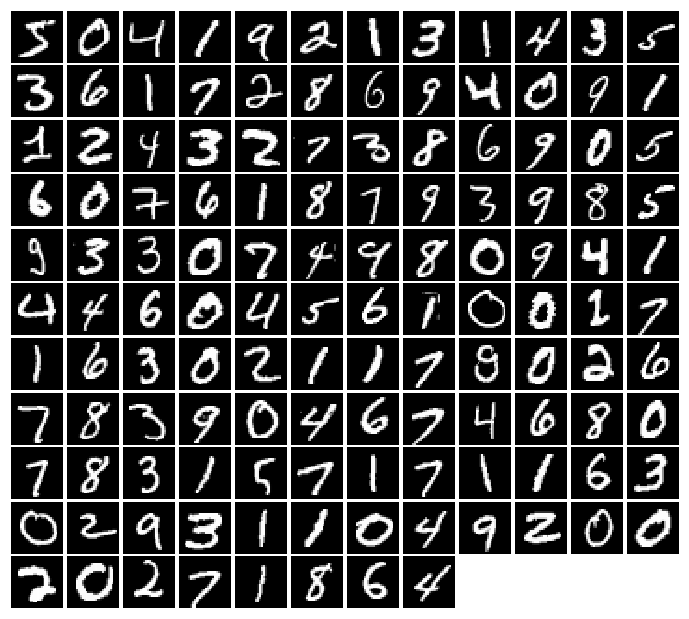

In [2]:
class ChunkSampler(sampler.Sampler):

    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

mnist_train = dset.MNIST('./MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

mnist_val = dset.MNIST('./MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))




imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

In [26]:
def sample_noise(batch_size, dim):
    
    a = 2*torch.rand(batch_size,dim)-1
    return a


In [27]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform(m.weight.data)

In [40]:
dtype = torch.cuda.FloatTensor
#if(torch.cuda.is_available()):
#    dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!


In [29]:
def discriminator():
    
    model = nn.Sequential(
        nn.Linear(784,256),
        nn.LeakyReLU(0.01),
        nn.Linear(256,256),
        nn.LeakyReLU(0.01),
        nn.Linear(256,1)
    )
    return model

In [30]:
def generator(noise_dim=NOISE_DIM):
    
    model = nn.Sequential(
        nn.Linear(noise_dim,1024),
        nn.ReLU(),
        nn.Linear(1024,1024),
        nn.ReLU(),
        nn.Linear(1024,784),
        nn.Tanh()
    )
    return model

In [31]:
def bce_loss(input, target):
    
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

In [32]:
def discriminator_loss(logits_real, logits_fake):
    
    size=logits_real.size()[0]
    true_labels=Variable(torch.ones(size)).type(dtype)
    fake_labels=Variable(torch.zeros(size)).type(dtype)
    l_real = bce_loss(logits_real,true_labels)
    l_fake = bce_loss(logits_fake , fake_labels)
    
    loss = l_real+l_fake
    return loss

def generator_loss(logits_fake):
    
    size=logits_fake.size()[0]
    fake_labels = Variable(torch.ones(size)).type(dtype)
    loss = bce_loss(logits_fake,fake_labels)
    return loss

In [15]:
def get_optimizer(model):
    
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3 , betas=(0.5, 0.999))
    return optimizer

In [38]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=100, 
              batch_size=128, noise_size=96, num_epochs=10):
    
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in loader_train:
            if len(x) != batch_size:
                continue
            D_solver.zero_grad()
            real_data = Variable(x).type(dtype)
            #print("real_data shape = ",real_data.size())
            #print("x shape = ", x.size())
            temp = 2* (real_data - 0.5)
            temp=temp.view(-1,784)
            #print("temp shape = ", temp.size())
            
            logits_real = D(temp).type(dtype)

            #logits_real = D(2* (real_data - 0.5)).type(dtype)

            g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
            fake_images = G(g_fake_seed).detach()
            logits_fake = D(fake_images.view(batch_size, 784))

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()        
            D_solver.step()

            G_solver.zero_grad()
            g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
            fake_images = G(g_fake_seed)
            
            gen_logits_fake = D(fake_images.view(batch_size, 784))
            #print("gen_logits_fake shape = ",gen_logits_fake.size())
            
            g_error = generator_loss(gen_logits_fake)
            g_error.backward()
            G_solver.step()
            #print("iter count =",iter_count)
            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.data[0],g_error.data[0]))
                imgs_numpy = fake_images.data.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1

Iter: 0, D: 1.342, G:0.6658


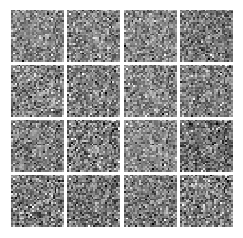

()
Iter: 100, D: 1.607, G:0.8853


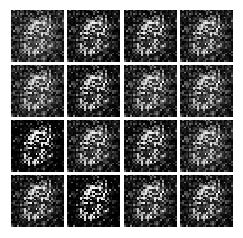

()
Iter: 200, D: 1.219, G:0.9324


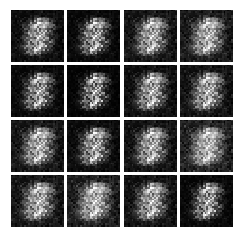

()
Iter: 300, D: 1.1, G:0.8244


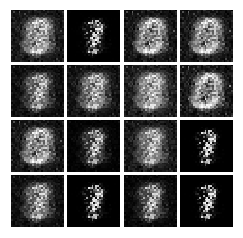

()
Iter: 400, D: 0.8986, G:1.523


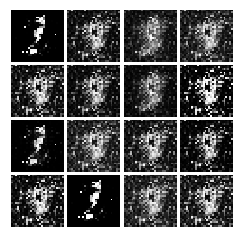

()
Iter: 500, D: 1.331, G:0.9585


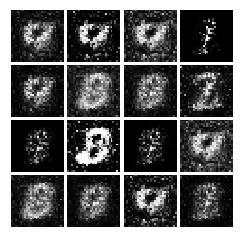

()
Iter: 600, D: 1.339, G:1.33


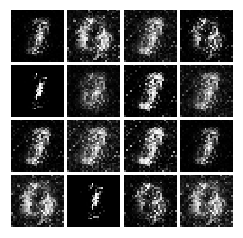

()
Iter: 700, D: 1.101, G:0.8881


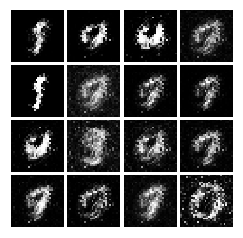

()
Iter: 800, D: 1.303, G:0.8422


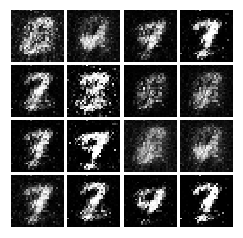

()
Iter: 900, D: 1.181, G:2.159


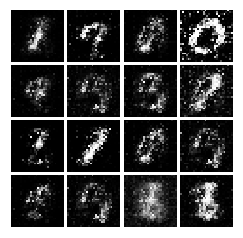

()
Iter: 1000, D: 1.309, G:0.9156


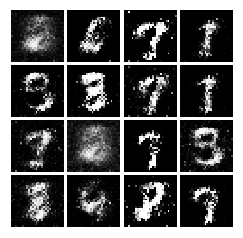

()
Iter: 1100, D: 1.137, G:2.076


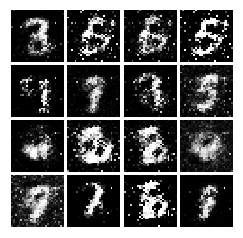

()
Iter: 1200, D: 1.205, G:0.9707


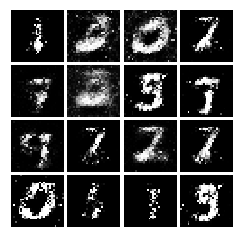

()
Iter: 1300, D: 1.121, G:1.158


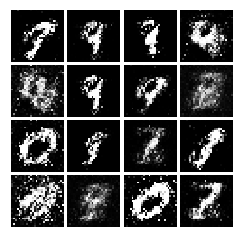

()
Iter: 1400, D: 1.209, G:0.9966


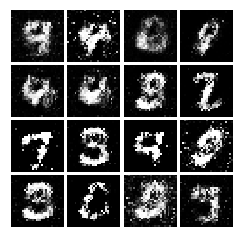

()
Iter: 1500, D: 1.229, G:0.936


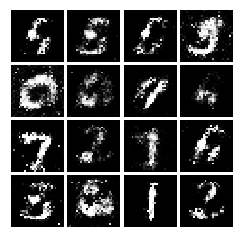

()
Iter: 1600, D: 1.299, G:1.072


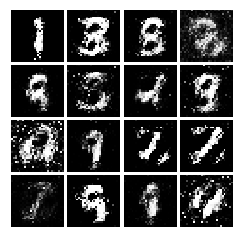

()
Iter: 1700, D: 1.395, G:0.8444


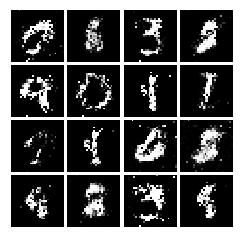

()
Iter: 1800, D: 1.244, G:0.99


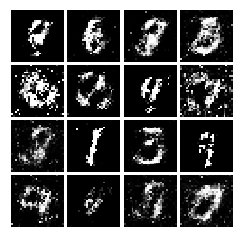

()
Iter: 1900, D: 1.132, G:0.9457


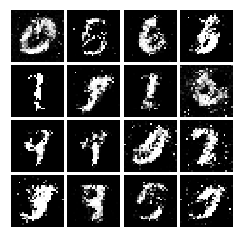

()
Iter: 2000, D: 1.338, G:1.13


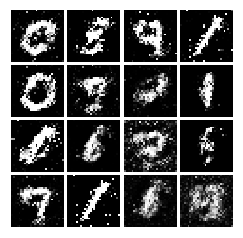

()
Iter: 2100, D: 1.4, G:0.6993


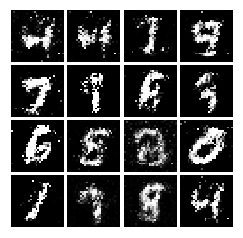

()
Iter: 2200, D: 1.362, G:0.861


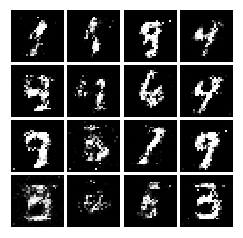

()
Iter: 2300, D: 1.257, G:0.9524


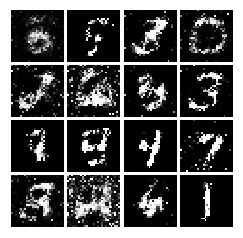

()
Iter: 2400, D: 1.391, G:0.7836


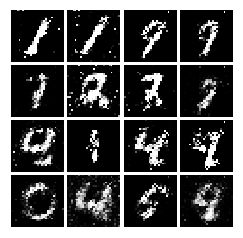

()
Iter: 2500, D: 1.204, G:0.9949


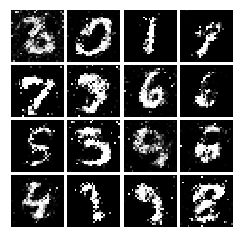

()
Iter: 2600, D: 1.202, G:0.8357


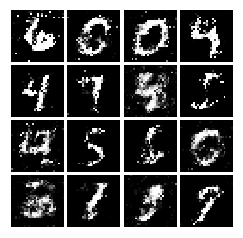

()
Iter: 2700, D: 1.256, G:0.883


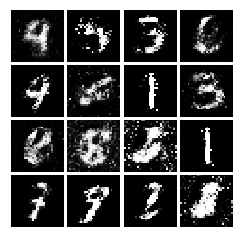

()
Iter: 2800, D: 1.305, G:0.8522


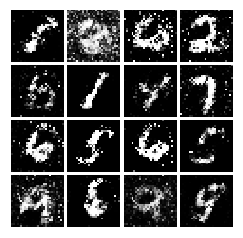

()
Iter: 2900, D: 1.38, G:0.8567


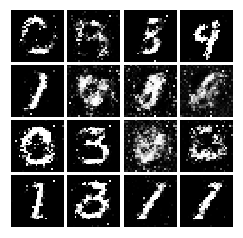

()
Iter: 3000, D: 1.434, G:0.7499


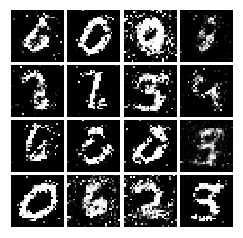

()
Iter: 3100, D: 1.294, G:0.8762


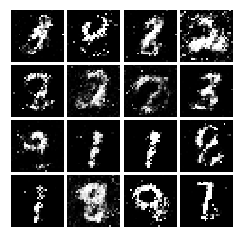

()
Iter: 3200, D: 1.331, G:0.7909


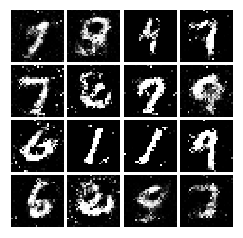

()
Iter: 3300, D: 1.3, G:0.8447


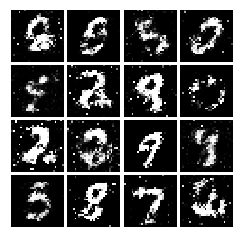

()
Iter: 3400, D: 1.258, G:0.9261


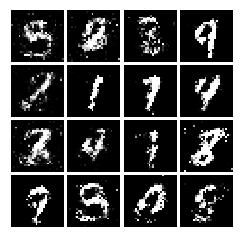

()
Iter: 3500, D: 1.246, G:0.8094


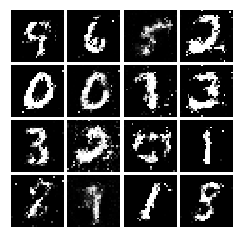

()
Iter: 3600, D: 1.274, G:1.039


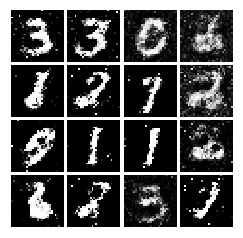

()
Iter: 3700, D: 1.334, G:0.7494


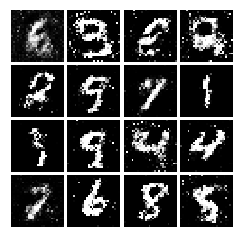

()
Iter: 3800, D: 1.369, G:0.8328


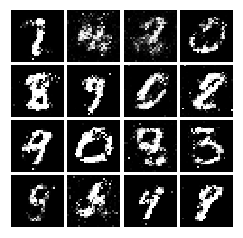

()


In [41]:
# Make the discriminator
D = discriminator().type(dtype)

# Make the generator
G = generator().type(dtype)

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)
# Run it!
run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss)

In [42]:
def ls_discriminator_loss(scores_real, scores_fake):
    
    r_mean=0.5*((scores_real-1)*(scores_real-1)).mean()
    l_mean=0.5*((scores_fake*scores_fake)).mean()
    loss = r_mean+l_mean
    return loss

def ls_generator_loss(scores_fake):
    
    
    temp = (scores_fake-1)*(scores_fake-1)
    loss=temp.mean()
    return loss*0.5

Iter: 0, D: 0.4316, G:0.4822


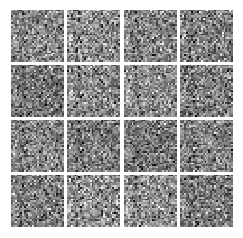

()
Iter: 100, D: 0.1159, G:0.5988


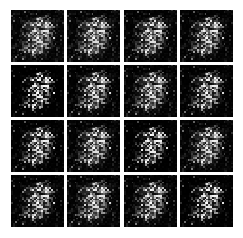

()
Iter: 200, D: 0.165, G:0.4564


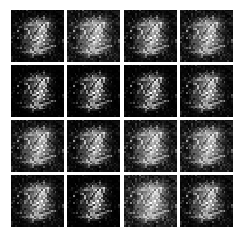

()
Iter: 300, D: 0.1696, G:0.1767


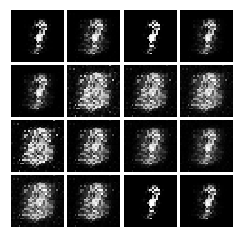

()
Iter: 400, D: 0.1358, G:0.4131


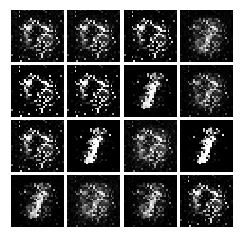

()
Iter: 500, D: 0.1793, G:0.2927


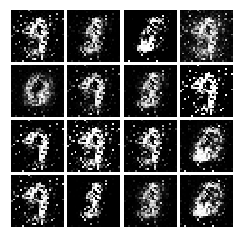

()
Iter: 600, D: 0.09883, G:0.4325


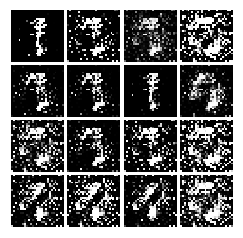

()
Iter: 700, D: 0.1533, G:0.4051


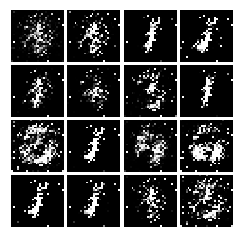

()
Iter: 800, D: 0.1681, G:0.2927


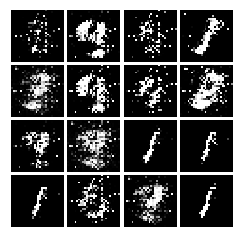

()
Iter: 900, D: 0.1937, G:0.311


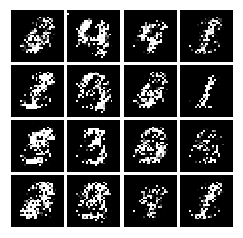

()
Iter: 1000, D: 0.2524, G:0.1903


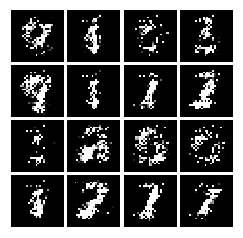

()
Iter: 1100, D: 0.09302, G:0.2451


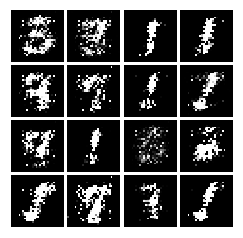

()
Iter: 1200, D: 0.1953, G:0.08252


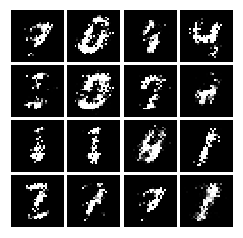

()
Iter: 1300, D: 0.1669, G:0.2394


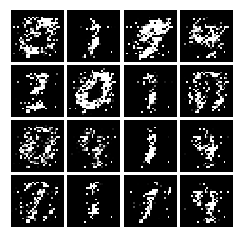

()
Iter: 1400, D: 0.1501, G:0.2547


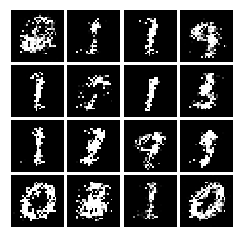

()
Iter: 1500, D: 0.1421, G:0.3013


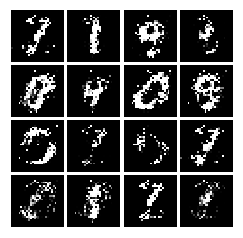

()
Iter: 1600, D: 0.1895, G:0.2377


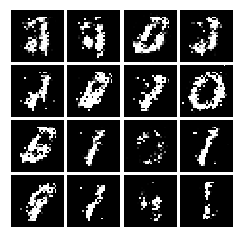

()
Iter: 1700, D: 0.1436, G:0.2392


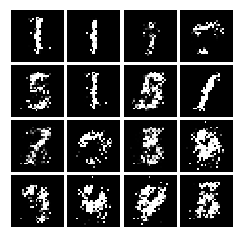

()
Iter: 1800, D: 0.1415, G:0.2455


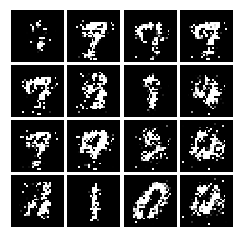

()
Iter: 1900, D: 0.1863, G:0.2432


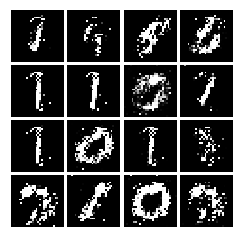

()
Iter: 2000, D: 0.2101, G:0.2093


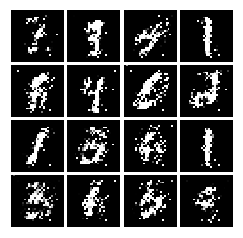

()
Iter: 2100, D: 0.1935, G:0.2017


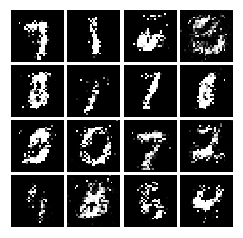

()
Iter: 2200, D: 0.2645, G:0.1803


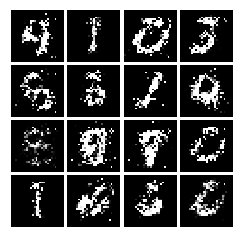

()
Iter: 2300, D: 0.2533, G:0.4795


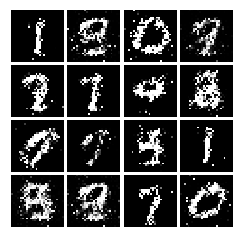

()
Iter: 2400, D: 0.2659, G:0.1627


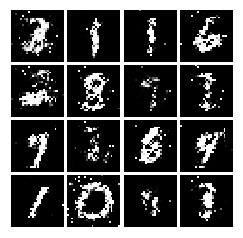

()
Iter: 2500, D: 0.2146, G:0.1721


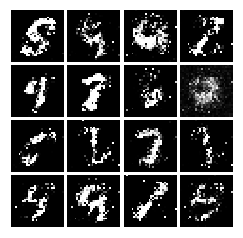

()
Iter: 2600, D: 0.2113, G:0.2488


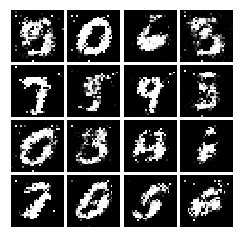

()
Iter: 2700, D: 0.2271, G:0.1579


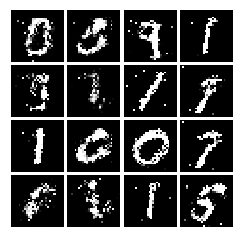

()
Iter: 2800, D: 0.2344, G:0.1957


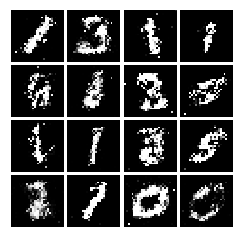

()
Iter: 2900, D: 0.2407, G:0.1669


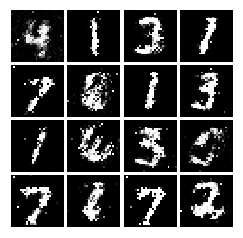

()
Iter: 3000, D: 0.2225, G:0.1671


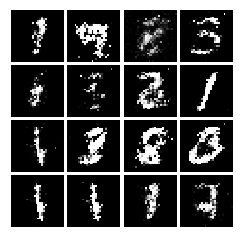

()
Iter: 3100, D: 0.2544, G:0.2051


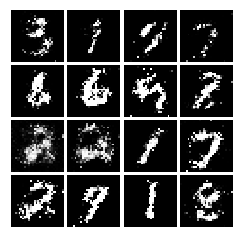

()
Iter: 3200, D: 0.2057, G:0.1831


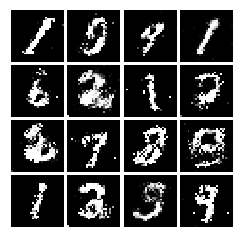

()
Iter: 3300, D: 0.23, G:0.1735


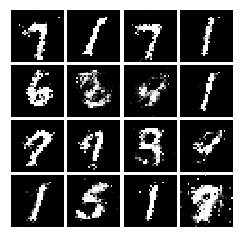

()
Iter: 3400, D: 0.232, G:0.1699


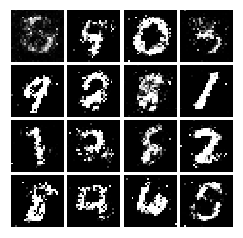

()
Iter: 3500, D: 0.2254, G:0.1582


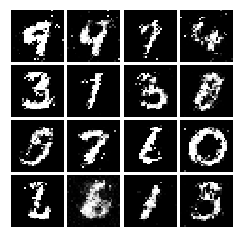

()
Iter: 3600, D: 0.2368, G:0.1519


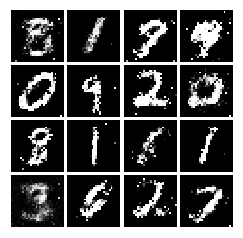

()
Iter: 3700, D: 0.2189, G:0.1728


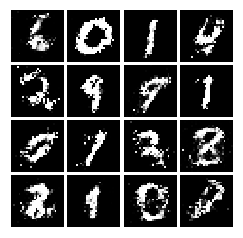

()
Iter: 3800, D: 0.2334, G:0.1673


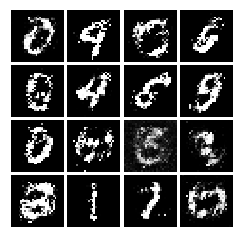

()


In [43]:
D_LS = discriminator().type(dtype)
G_LS = generator().type(dtype)

D_LS_solver = get_optimizer(D_LS)
G_LS_solver = get_optimizer(G_LS)

run_a_gan(D_LS, G_LS, D_LS_solver, G_LS_solver, ls_discriminator_loss, ls_generator_loss)

In [44]:
def build_dc_classifier():

    return nn.Sequential(
        
        ###########################
        ######### TO DO ###########
        ###########################
        Unflatten(batch_size, 1, 28, 28),
        nn.Conv2d(1,32,5,stride=1),
        nn.LeakyReLU(0.01),
        nn.MaxPool2d(2,stride=2),
        nn.Conv2d(32,64,5,stride=1),
        nn.LeakyReLU(0.01),
        nn.MaxPool2d(2,stride=2),
        Flatten(),
        nn.Linear(1024,1024),
        nn.LeakyReLU(0.01),
        nn.Linear(1024,1)
        
    )

data = Variable(loader_train.__iter__().next()[0]).type(dtype)
b = build_dc_classifier().type(dtype)
out = b(data)
print(out.size())

torch.Size([128, 1])


In [45]:
def build_dc_generator(noise_dim=NOISE_DIM):
   
    return nn.Sequential(
        nn.Linear(noise_dim,1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        nn.Linear(1024,7*7*128),
        nn.BatchNorm1d(7*7*128),
        Unflatten(batch_size,128,7,7),
        nn.ConvTranspose2d(128,64,4,stride=2,padding=(1,1)),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(64,1,4,stride=2,padding=(1,1)),
        nn.Tanh(),
        Flatten()
        
        
    )

test_g_gan = build_dc_generator().type(dtype)
test_g_gan.apply(initialize_weights)

fake_seed = Variable(torch.randn(batch_size, NOISE_DIM)).type(dtype)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

torch.Size([128, 784])

Iter: 0, D: 1.426, G:0.1386


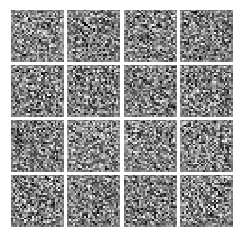

()
Iter: 100, D: 1.502, G:0.3165


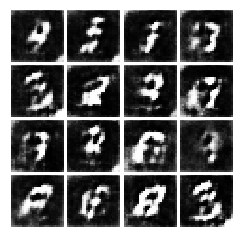

()
Iter: 200, D: 1.266, G:1.0


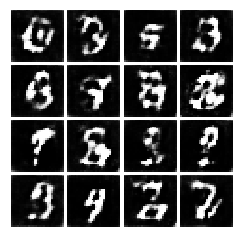

()
Iter: 300, D: 1.055, G:1.514


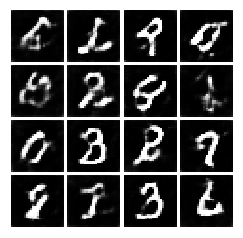

()
Iter: 400, D: 1.255, G:1.088


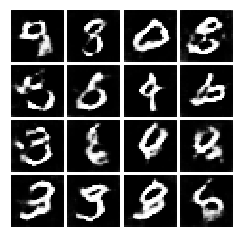

()
Iter: 500, D: 1.129, G:1.072


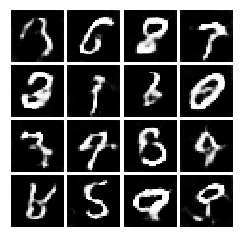

()
Iter: 600, D: 0.9837, G:1.109


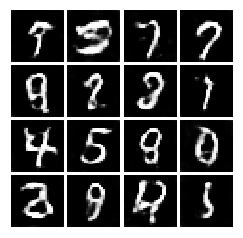

()
Iter: 700, D: 1.098, G:0.9186


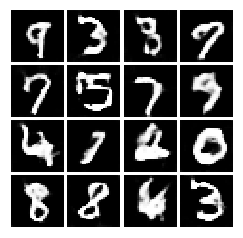

()
Iter: 800, D: 1.098, G:0.6653


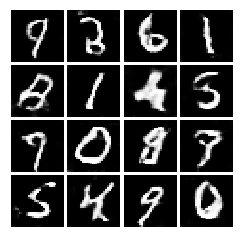

()
Iter: 900, D: 1.008, G:1.18


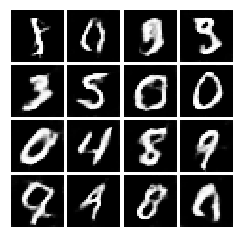

()
Iter: 1000, D: 1.348, G:1.259


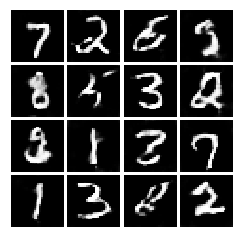

()
Iter: 1100, D: 0.9662, G:1.529


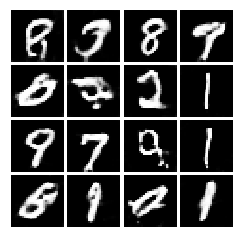

()
Iter: 1200, D: 0.9863, G:1.247


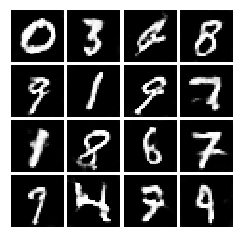

()
Iter: 1300, D: 1.084, G:1.227


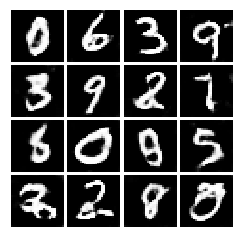

()
Iter: 1400, D: 1.241, G:1.147


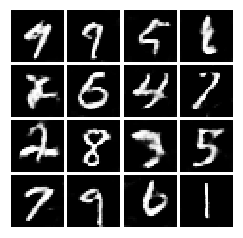

()
Iter: 1500, D: 1.041, G:1.275


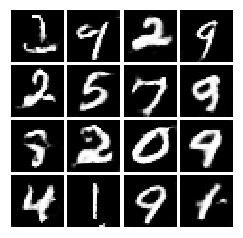

()
Iter: 1600, D: 1.092, G:1.145


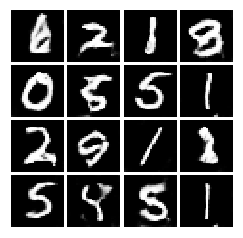

()
Iter: 1700, D: 1.095, G:0.9799


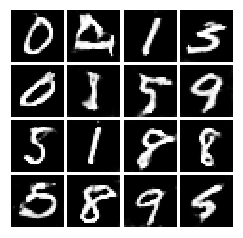

()
Iter: 1800, D: 1.02, G:0.849


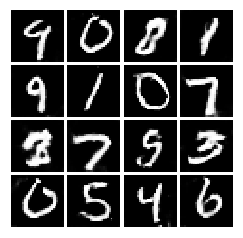

()
Iter: 1900, D: 0.9483, G:1.248


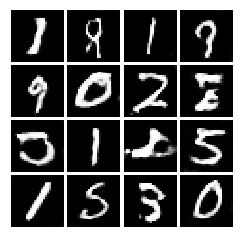

()


In [46]:
D_DC = build_dc_classifier().type(dtype) 
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, num_epochs=5)